## Bibliotecas Utilizadas

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import regex as re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from operator import itemgetter

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [4]:
# Function to remove emoji.
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [5]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

# Carregando os dados 

In [6]:
# Dict com os pliticos e seus Dataframes
politicos = {}
lista_dir = os.listdir("./politicos/")
nome_politicos = []
for nome in lista_dir:
    politicos[nome[:-4]] = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    nome_politicos.append(nome[:-4])

In [12]:
# Dataframe com todos os politicos e seus tweets
lista_dir = os.listdir("./politicos/")
nome_politicos = []
df_politicos = pd.DataFrame()
for nome in lista_dir:
    df_politico = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    df_politico['nome'] = nome[:-4]
    nome_politicos.append(nome[:-4])
    df_politicos = df_politicos.append(df_politico)
    cols = ['nome'] + [col for col in df_politicos if col != 'nome']
    df_politicos = df_politicos[cols]

## Unindo Doria(1), Bolsonaro(2) e Lula(3) em um dataframe

In [22]:
# stopwords e simbolos a retirar
stop_words_portugues = set(['de','a','o','que','e','é','do','da','em','um','para','com','não','uma','os','no','se','na','por','mais','as','dos','como','mas','ao','ele','das','à','seu','sua','ou','quando','muito','nos','já','eu','também','só','pelo','pela','até','isso','ela','entre','depois','sem','mesmo','aos','seus','quem','nas','me','esse','eles','você','essa','num','nem','suas','meu','às','minha','numa','pelos','elas','qual','nós','lhe','deles','essas','esses','pelas','este','dele','tu','te','vocês','vos','lhes','meus','minhas','teu','tua','teus','tuas','nosso','nossa','nossos','nossas','dela','delas','esta','estes','estas','aquele','aquela','aqueles','aquelas','isto','aquilo','estou','está','estamos','estão','estive','esteve','estivemos','estiveram','estava','estávamos','estavam','estivera','estivéramos','esteja','estejamos','estejam','estivesse','estivéssemos','estivessem','estiver','estivermos','estiverem','hei','há','havemos','hão','houve','houvemos','houveram','houvera','houvéramos','haja','hajamos','hajam','houvesse','houvéssemos','houvessem','houver','houvermos','houverem','houverei','houverá','houveremos','houverão','houveria','houveríamos','houveriam','sou','somos','são','era','éramos','eram','fui','foi','fomos','foram','fora','fôramos','seja','sejamos','sejam','fosse','fôssemos','fossem','for','formos','forem','serei','será','seremos','serão','seria','seríamos','seriam','tenho','tem','temos','tém','tinha','tínhamos','tinham','tive','teve','tivemos','tiveram','tivera','tivéramos','tenha','tenhamos','tenham','tivesse','tivéssemos','tivessem','tiver','tivermos','tiverem','terei','terá','teremos','terão','teria','teríamos','teriam'])
stop_words_ingles = set(stopwords.words('english'))
stop_words_espanhol = set(stopwords.words('spanish'))
symbols = set(['-', 'r$', 'R$', '.', '|'])

dados = set()
for politico in politicos:
    # separando as palavras
    palavras = "".join(politicos[politico]['text']).lower().split()
    # retirando stopwords e depois os web links
    palavras = [w for w in palavras if not w in (stop_words_portugues | stop_words_espanhol | stop_words_ingles | symbols)]
    palavras = [w for w in palavras if re.match(r'http*', w) == None]
    palavras = [w for w in palavras if not w.startswith('@')]
    palavras = [w for w in palavras if not w.startswith('#')]
    palavras = [w for w in palavras if w != 'rt']
    # gerando a frequência das palavras
    c = Counter(palavras)
    # retirando palavras com frequencia menor do que 10 e adicionando o nome do candidato
    d = {(politico,x,y) for x,y in zip(c,c.values()) if y > 10}
    print(politico, len(d))
    for x in d:
        dados.add(x)

# montando o dataframe
df = pd.DataFrame(dados, columns=['candidato', 'texto', 'frequencia'])

Amoedo 988
Bolsonaro 661
Boulos 661
Ciro 516
Doria 799
Huck 438
Leite 1092
Lula 713
Mandetta 241
Marina 906
Moro 294


In [23]:
df.head(50)

candidato            texto  frequencia
0        Huck     compartilhar          17
1       Doria            forma          63
2      Marina          postura          47
3        Ciro        congresso          11
4   Bolsonaro       importação          18
5       Leite             mapa          26
6      Amoedo          mandato          11
7        Lula         destruiu          16
8        Huck         parabens          42
9        Lula             lula         602
10      Leite       envolvendo          12
11     Marina              pra         122
12       Ciro            bater          12
13     Marina      assassinato          15
14     Amoedo     funcionários          15
15     Marina             pede          14
16     Marina          cidades          15
17     Marina          esforço          19
18      Leite            temas          27
19     Amoedo         controle          11
20       Moro         polícias          27
21       Moro            geral          14
22       Ciro             cada          35
23  Bolsonaro           sempre          40
24     Marina       representa          14
25      Leite         carreira          11
26     Marina             usar          18
27     Marina             fala          35
28       Lula          partido          37
29     Amoedo        significa          12
30      Doria         vacinas.          11
31      Leite             uti,          15
32       Moro       ministério          31
33      Doria         oficiais          32
34     Amoedo          ataques          13
35     Boulos         combater          25
36      Leite           doença          14
37     Amoedo               mp          11
38      Leite         milhões.          36
39      Leite        nacional.          11
40      Doria       seguiremos          19
41     Boulos               30          14
42       Ciro        vacinação          14
43      Doria  desenvolvimento          41
44       Ciro            maior          76
45      Leite        receberão          11
46     Amoedo         milhares          19
47     Amoedo           fundão          31
48      Leite           região          68
49      Leite    funcionamento          16

In [25]:
df.sort_values('frequencia', ascending=True)[:20]

candidato        texto  frequencia
2907       Huck  iniciativa.          11
3127  Bolsonaro      imóveis          11
5282       Ciro        vivo:          11
5273       Lula          est          11
1277     Amoedo        basta          11
5261     Amoedo     oxigênio          11
3138      Doria        longo          11
5246       Ciro  roubalheira          11
5240     Boulos       parece          11
3146     Marina     acontece          11
3152       Ciro        anos,          11
5227     Amoedo      despesa          11
5222  Bolsonaro       demais          11
638        Lula      nenhuma          11
5217      Doria          500          11
3157     Amoedo  brasileiras          11
5211     Amoedo          pgr          11
3161       Huck           e,          11
3165       Ciro            2          11
1266       Moro    toneladas          11

## WordCloud de todos

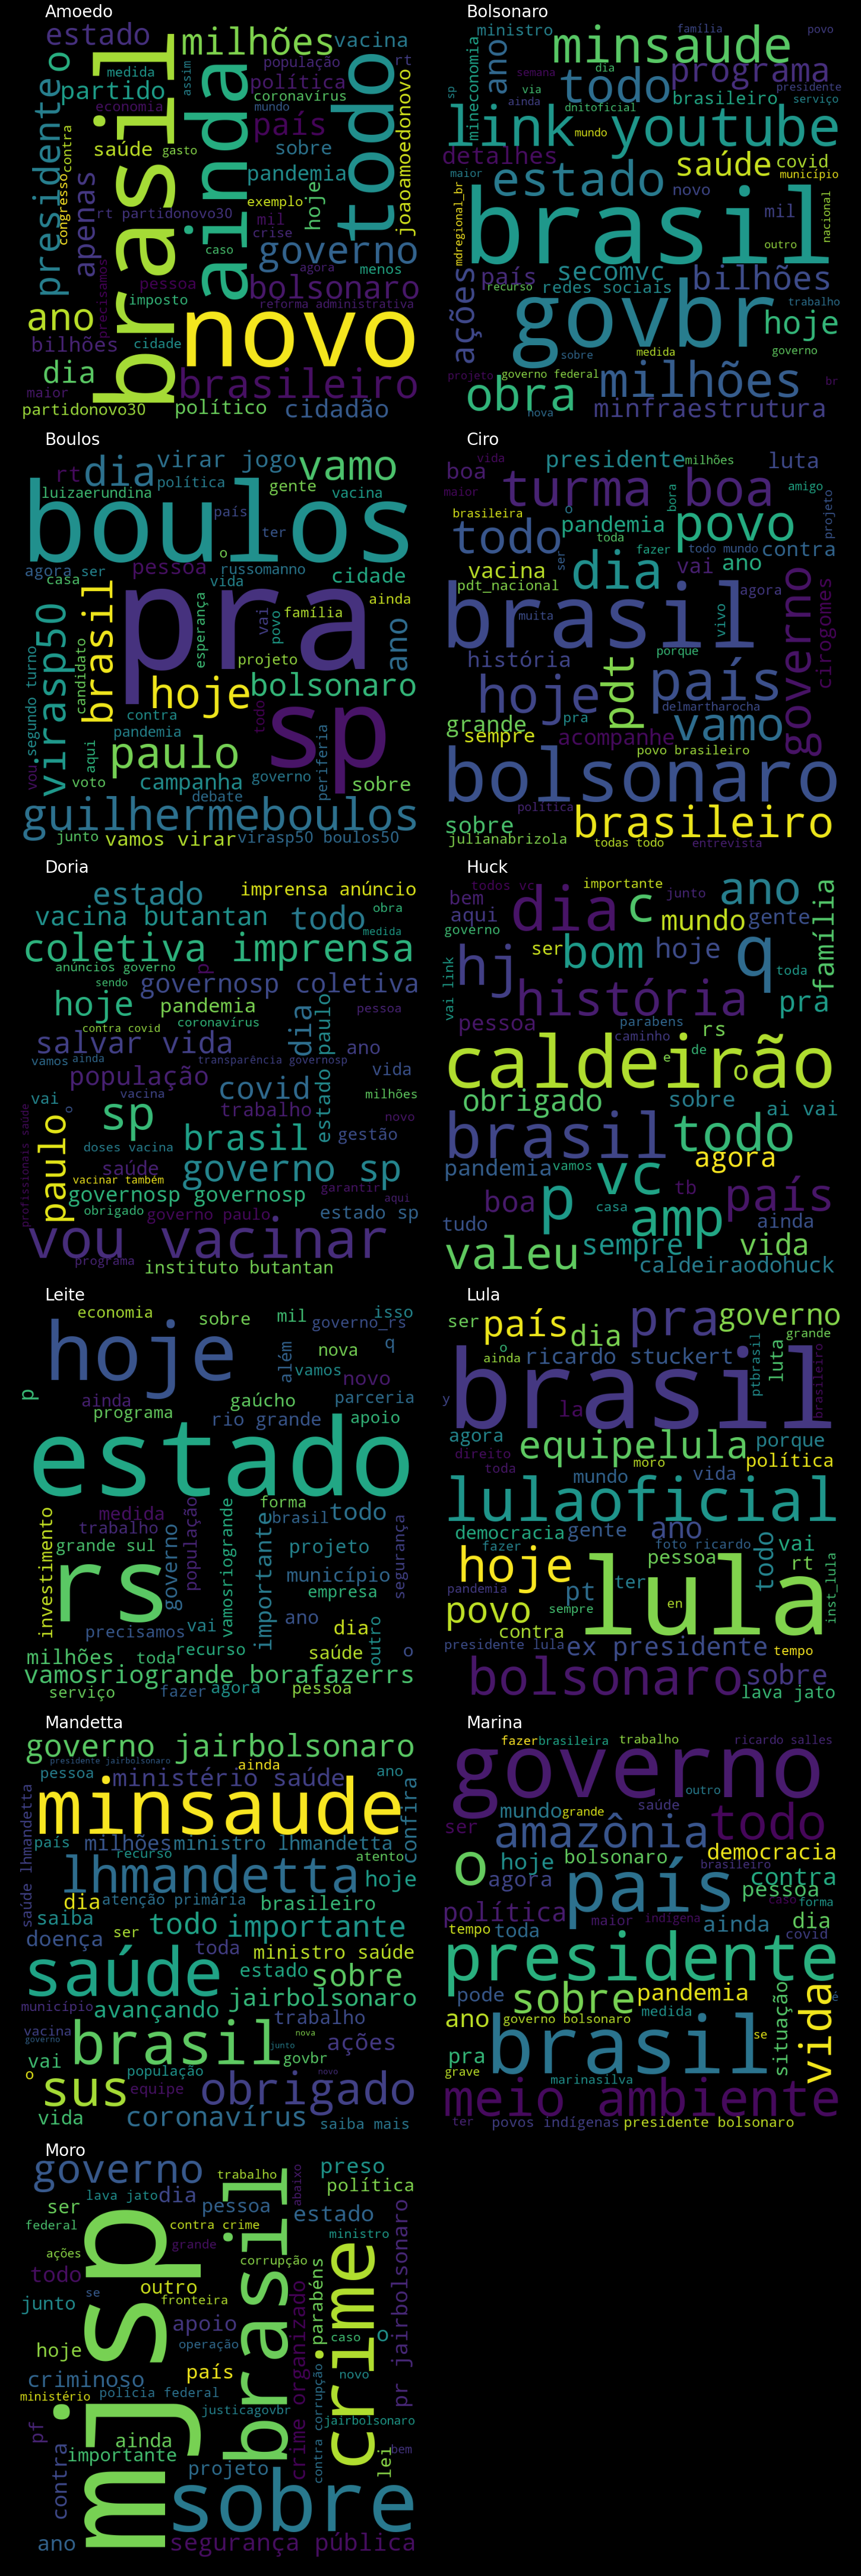

In [21]:
palavras = []
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 60), facecolor='k')
xc = 0
yc = 0
for idx in range(11):
    palavras.append("".join(politicos[nome_politicos[idx]]['text']).lower().split())
    palavras[idx] = [w for w in palavras[idx] if not w in (stop_words | symbols)]
    palavras[idx] = [w for w in palavras[idx] if re.match(r'https://*', w) == None]
    sumario = " ".join(s for s in palavras[idx])
    wordcloud = WordCloud(width=800, height=800, max_words=50).generate(sumario)
    ax[xc][yc].imshow(wordcloud)
    ax[xc][yc].text(50, -10, nome_politicos[idx], fontsize=28, color='white')
    yc += 1
    if (yc == 2):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.axis('off')
plt.tight_layout(pad=0) 
plt.show()

## LDA - Latent Dirichlet Allocation - Modelagem de Tópicos

In [ ]:
# stopwords e simbolos a retirar
stop_words = set(stopwords.words('portuguese'))
symbols = set(['-', 'r$', 'R$', '.'])

for idx in range(len(nome_politicos)):
    politicos[nome_politicos[idx]]['tweet_token'] = 'NaN'
    tweets = politicos[nome_politicos[idx]]['text']
    for index, row in politicos[nome_politicos[idx]].iterrows():
        tweet = row['text'].lower()
        tweet_token = [w for w in tweet.split() if not w in (stop_words | symbols)]
        tweet_token = [w for w in tweet_token if re.match(r'http*', w) == None]
        tweet_token = [w for w in tweet_token if not w.startswith('@')]
        tweet_token = [w for w in tweet_token if not w.startswith('#')]
        tweet_token = [w for w in tweet_token if w != 'rt']

        politicos[nome_politicos[idx]].loc[index, 'tweet_token'] = emoji(" ".join(tweet_token))

In [ ]:
dfp = pd.DataFrame(politicos['Amoedo'])
dfp['nome'] = "Amoedo"
dfp

In [ ]:
tweets = list()
for politico in nome_politicos:
    tweets.extend(list(politicos[politico]['tweet_token']))

tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(tweets)

lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)
lda.fit(tf)

n_top_words = 3
print("\nTópico no Modelo LDA: ")
print("*"*70)
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

## LDA - Latent Dirichlet Allocation - Modelagem de Tópicos Politicos

In [ ]:
tf_vectorizer = CountVectorizer()
for politico in nome_politicos:
    tf = tf_vectorizer.fit_transform((list(politicos[politico]['tweet_token'])))
    lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                    learning_method = 'online',
                                    learning_offset = 50.,
                                    random_state = 0)
    lda.fit(tf)

    n_top_words = 3
    print(f"\nTópico no Modelo LDA: {politico}")
    print("*"*70)
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)